<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/OU_process/Models/standard_pinn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.nn import ReLU
from torch.utils.data import Dataset, DataLoader
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.integrate as integrate
import scipy.special as special
import scipy.ndimage as ndimage

# Solving for the MET of an Ornstein-Uhlenbeck process in a disk with "Standard PINNs" : comparison with exact solution

## 1) Setup

For $\theta,\sigma,r >0$ some fixed parameters, we let $\Omega := B_r \equiv \{x\in\mathbb R^d : \|x\|< r \}$, and define the process ($d=2$ in our illustration) :

$$\begin{cases} dX_t &= -\theta X_t dt + \sigma dB_t \\
X_0 &= x \in \Omega \end{cases} $$

For all $x\in\Omega$, let

$$T(x) := \inf\{t\ge 0 : X_t \in\partial\Omega\} $$

and let its first moment be denoted

$$\tau(x) := \mathbb E[T(x)] $$

We can show under some regularity conditions on $\Omega$ that $\tau$ is the (unique) solution of the BVP :

$$\begin{cases} \mathcal{L}u(x) &= -1 \text{ for all } x\in\Omega \\
u(x) &= 0 \text{ for all } x\in\partial\Omega \end{cases} $$

where $\mathcal L$ is the infinitesimal generator of the Ornstein-Uhlenbeck process, given by
$$\mathcal Lu : x \mapsto -\theta x \cdot \nabla u(x) + \frac{\sigma^2}{2}\Delta u(x) $$

Nicely enough, for this problem, we can compare our solution with the known closed-form solution (see https://arxiv.org/abs/2208.04029) :

$$ \tau(x) := \frac{1}{\lambda^{d/2}\sigma^2}\int_\rho^r z^{1-d} e^{\lambda z^2} \gamma(d/2, \lambda z^2)\ dz $$

where $\lambda := \theta/\sigma^2 $, $\rho := \|x\| $ and $\gamma$ is the upper incomplete gamma function :
$$\gamma(n,y) := \int_0^y t^{n-1} e^{-t}\ dt.  $$

In [2]:
#radius of the ball
radius = 2

#parameters of the OU process
theta = 1
sigma = 0.5
lambda_ = theta/sigma**2

#definition of the true solution for comparison

def true_solution(x, y, theta=theta, lambda_=lambda_):
    rho = np.sqrt(x**2 + y**2)
    integral, _ = integrate.quad(lambda t : np.exp(lambda_ * t**2) * special.gammainc(1, lambda_ * t**2) / t, rho, radius)
    return integral/theta

#make the true_solution compatible with numpy arrays
true_solution_vectorized = np.vectorize(true_solution)

#plotting the function (inspiration taken from https://stackoverflow.com/questions/27606079)
n_points = 400
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid

xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0) #(https://stackoverflow.com/questions/15733530/)
zz = true_solution_vectorized(xx,yy)

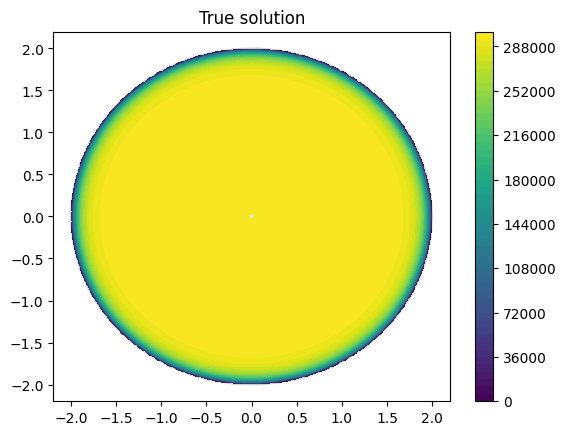

In [3]:
#circle
a = np.linspace(0, 2*np.pi, 50)
cx,cy = np.cos(a) * radius , np.sin(a)*radius

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)

contour = ax.contourf(xx, yy, zz, levels=50)  # 50 contour levels
ax.set_title("True solution")
cb = fig.colorbar(contour, ax=ax)

As we can see, the true solution blows up extremely fast away from the boundary, and is thus likely to be hard to learn.

## 2) Setting up the Neural Network architecture and loss function
We are training a shallow neural network to learn $\tau(x)$ by using the standard PINN algorithm in its most "basic" version, we solve for the objective
$$\hat u := \arg\min_{u\in\mathcal{NN}}\ \frac1n \sum_{i=1}^n (\mathcal L u(x_i^c) + 1)^2 + \frac1n \sum_{i=1}^n u(x_i^b)^2$$
where $x_i^c,x_i^b$ are sampled i.i.d. with uniform distribution on $\Omega$ and $\partial\Omega$ respectively,
$$\mathcal{NN}:=\left\{x\mapsto \sum_{i=1}^m \beta_i\ \sigma_k(\theta_i\cdot x + \omega_i)\mid (\beta_i,\omega_i, \theta_i)\in\mathbb R^{2+d}\right\} $$
and
$$\sigma_k :x \mapsto \begin{cases}x^k &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} $$
is the ReLU$^k$ activation.

In [55]:
#define ReLU^k activation and NN architecture
power = 2
width = 100
magnitude = 5 #magnitude of weights at initialization

class RePU(nn.Module):

    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)


class StandardPINN(nn.Module):

    def __init__(self, power = 2, width = width):
        super().__init__()

        self.layers = torch.nn.Sequential(torch.nn.Linear(2, width),
                                          RePU(power),
                                          torch.nn.Linear(width, 1))

    def forward(self, x):
        return self.layers(x)


In [56]:
#all functions needed for training

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    This function calculates the derivative of the model at x
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

def u_function(model: StandardPINN, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the model on the input x
    """
    model_input = torch.stack((x, y), axis = 1)
    return model(model_input)


def residual(model, x_c, y_c):
    u = u_function(model, x_c, y_c)
    u_x = derivative(u, x_c, order=1)
    u_y = derivative(u, y_c, order=1)
    u_xx = derivative(u, x_c, order=2)
    u_yy = derivative(u, y_c, order=2)
    res = - theta * (x_c * u_x + y_c * u_y) \
        + sigma**2 * (u_xx + u_yy)/2 \
        + 1
    return res

def loss_function(model: StandardPINN, x_c: torch.Tensor, y_c: torch.Tensor, x_b: torch.Tensor, y_b: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the physics governing the model on the input x
    """
    domain_residual = residual(model, x_c, y_c).pow(2).mean() #residual
    boundary_residual = (u_function(model, x_b, y_b)).pow(2).mean() #boundary
    return domain_residual +  boundary_residual

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=magnitude)
        m.bias.data.fill_(magnitude)

In [ ]:

# def closure(model: StandardPINN, optimizer, X_c_train: torch.Tensor, X_b_train:torch.Tensor) -> torch.Tensor:
#     """
#     In order to use the LBFGS optimizer, we need to define a closure function. This function is called by the optimizer
#     and the optimizer contains the inner loop for the optimization and it continues until the tolerance is met.
#     """
#     x_c = X_c_train[0, :]
#     y_c = X_c_train[1, :]
#     x_b = X_b_train[0, :]
#     y_b = X_b_train[1, :]
#     optimizer.zero_grad()
#     loss = loss_function(model, x_c, y_c, x_b, y_b)
#     loss.backward()
#     global iter
#     iter += 1
#     print(f" iteration: {iter}  loss: {loss.item()}")
#     losses.append(loss.item())
#     return loss

# def train(model, X_c_train, X_b_train, n_epochs = n_epochs):
#     # Initialize the optimizer
#     closure_fn = partial(closure, model, optimizer, X_c_train, X_b_train)

#     if method == 'LBFGS':
#         optimizer = torch.optim.LBFGS(model.parameters(),
#                                         lr=1,
#                                         max_iter=10,
#                                         #max_eval=50000,
#                                         #history_size=50,
#                                         tolerance_grad=1e-05,
#                                         tolerance_change=0.5 * np.finfo(float).eps,
#                                         line_search_fn="strong_wolfe")

#         for i in range(n_epochs):
#         #the optimizer.step requires the closure function to be a callable function without inputs
#         #therefore we need to define a partial function and pass it to the optimizer
#             optimizer.step(closure_fn)

#     elif method == 'Adam':
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 3) Preparation of the training data  

sampling $n = N_c$ collocation points in $\Omega$ and $n = N_b$ boundary points on $\partial \Omega $

In [57]:
N_c = 1000 #number of points in the domain (ie collocation points)
N_b = N_c #number of points on the boundary

#definition of X_c_train : N_c points in the disk
t = np.random.uniform(0,2*np.pi, N_c)
rho = np.sqrt(np.random.uniform(0,radius**2, N_c)) #uniform distribution on the disk
x_c = rho * np.cos(t)
y_c = rho * np.sin(t)
X_c_train = np.vstack( (x_c, y_c) )

#shuffling X_c_train
index = np.arange(0, N_c)
np.random.shuffle(index)
X_c_train = X_c_train[:,index]

#definition of X_b_train : N_b points on the boundary
t = np.random.uniform(0, 2*np.pi, N_b)
x_b = radius * np.cos(t)
y_b = radius * np.sin(t)
X_b_train = np.vstack( (x_b, y_b) )

#shuffling X_b_train
index = np.arange(0, N_b)
np.random.shuffle(index)
X_b_train = X_b_train[:, index]


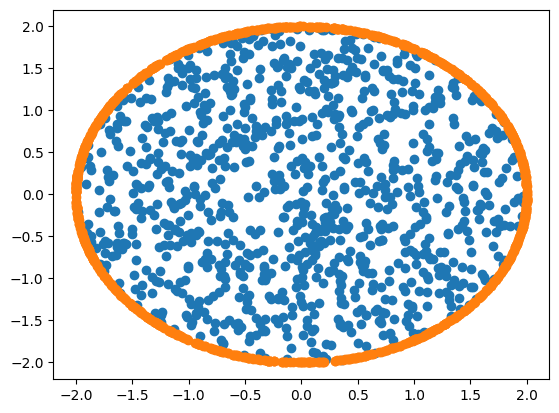

In [58]:
#checking the collocation and boundary points
plt.scatter(x_c,y_c)
plt.scatter(x_b,y_b)

In [59]:
class TrainingData(Dataset):
    def __init__(self, X_c, X_b):
        self.X_c = X_c
        self.X_b = X_b

    def __len__(self):
        return self.X_c.shape[1]

    def __getitem__(self, index):
        X_c = self.X_c[:, index]
        X_b = self.X_b[:, index]
        return (X_c, X_b)

In [60]:
#training parameters
batch_size = 4
learning_rate_adam = 1e-4
learning_rate_sgd = 5e-4
dampening = learning_rate_sgd/10
method = 'Adam' #'SGD' or 'Adam'
losses = []

#model instantiation
model = StandardPINN()
model.apply(init_weights)

# Training
X_c_train_tensor = torch.from_numpy(X_c_train).requires_grad_(True).float()
X_b_train_tensor = torch.from_numpy(X_b_train).requires_grad_(True).float()

dataset = TrainingData(X_c_train_tensor, X_b_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

if method == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)

elif method == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_sgd, dampening=dampening)

elif method not in ['Adam', 'SGD']:
    raise ValueError('You need to specify Adam or SGD as a training method')

In [61]:
#code adapted from https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train_one_epoch(model, epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(dataloader):

        X_c = data[0]
        X_b = data[1]

        x_c = X_c[0,:]
        y_c = X_c[1,:]
        x_b = X_b[0,:]
        y_b = X_b[1,:]

        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss = loss_function(model, x_c, y_c, x_b, y_b)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 29 == 28:
            last_loss = running_loss / 29 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            losses.append(last_loss)
            running_loss = 0.

    return last_loss

In [62]:
n_epochs = 500
epoch_number = 0

for epoch in range(n_epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(model, epoch_number)
    print('LOSS train {}'.format(avg_loss))
    epoch_number += 1

EPOCH 1:
  batch 29 loss: 26648.382534684806
  batch 58 loss: 29605.8529179014
  batch 87 loss: 27109.89242658944
  batch 116 loss: 25303.40785796067
  batch 145 loss: 15155.505876212284
  batch 174 loss: 16251.162917564656
  batch 203 loss: 18315.606849407326
  batch 232 loss: 15583.658409381735
LOSS train 15583.658409381735
EPOCH 2:
  batch 29 loss: 12772.416015625
  batch 58 loss: 13591.364788186962
  batch 87 loss: 12752.5299745757
  batch 116 loss: 11822.721721780712
  batch 145 loss: 7164.902053306842
  batch 174 loss: 7632.277857287177
  batch 203 loss: 8308.762819487472
  batch 232 loss: 7274.281121615706
LOSS train 7274.281121615706
EPOCH 3:
  batch 29 loss: 5703.771888469828
  batch 58 loss: 5868.49688089305
  batch 87 loss: 5722.716580094962
  batch 116 loss: 5212.605546622441
  batch 145 loss: 3234.6549745757006
  batch 174 loss: 3357.884412042026
  batch 203 loss: 3557.4783672464305
  batch 232 loss: 3222.4907942147092
LOSS train 3222.4907942147092
EPOCH 4:
  batch 29 loss

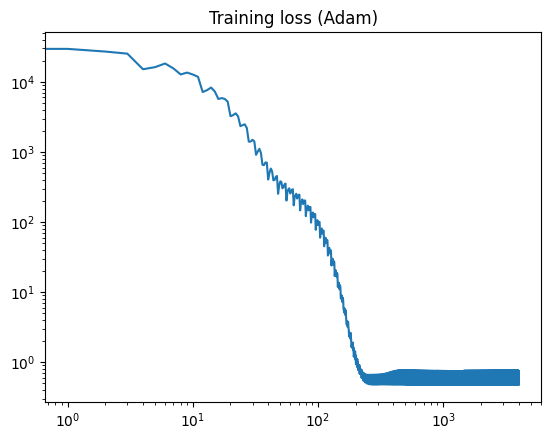

In [63]:
plt.loglog(losses)
plt.title(f'Training loss ({method})')
plt.show()

In [64]:
# save the model
torch.save(model.state_dict(), f'standard_pinn_{method}.pt')

<ipython-input-65-91ae52dd1054>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f'standard_pinn_{method}.pt'))


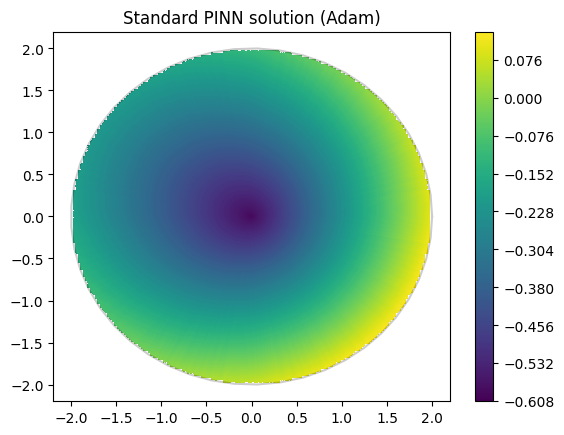

In [65]:
#load the model
model = StandardPINN()
model.load_state_dict(\
torch.load(f'standard_pinn_{method}.pt'))

#evaluate the model on a uniform grid
n_points = 150
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid
xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0) #(https://stackoverflow.com/questions/15733530/)
zz_true = true_solution_vectorized(xx,yy)

input = torch.from_numpy(np.vstack((xx.ravel(),yy.ravel())).T).float()#.requires_grad_(False)
learned_sol = model(input)

#plot
learned_sol_np = learned_sol.detach().numpy().reshape(xx.shape)
#learned_sol_smooth = ndimage.gaussian_filter(learned_sol_np, sigma=0.1, order=0) #smoothing for visualization

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)
contour = ax.contourf(xx, yy, learned_sol_np, levels=200)
ax.set_title(f'Standard PINN solution ({method})')
cb = fig.colorbar(contour, ax=ax)